In [135]:
from prophet import Prophet
from pmdarima.arima import auto_arima

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
## Leitura do csv
df = pd.read_csv('../../Data/Raw/crimes_por_mes_RS.csv', parse_dates=['MÊS'], index_col='MÊS')
df.index.freq = 'MS'

In [137]:
## Verificação da estacionaridade da série temporal
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df['AMEAÇA'])

(0.01, False)

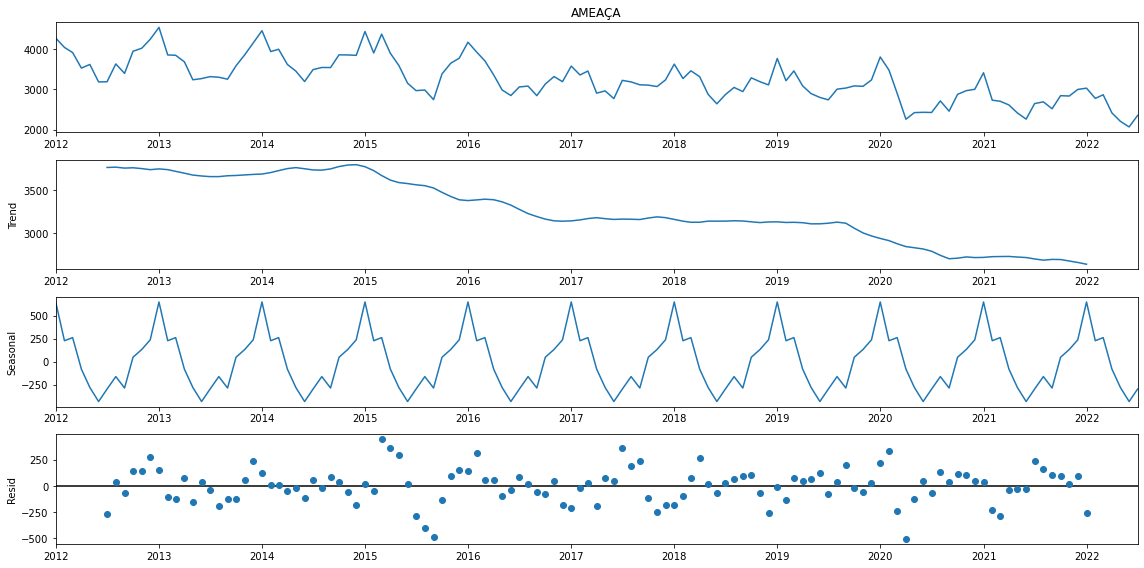

In [138]:
## Decomposição da série temporal
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['AMEAÇA'], model='additive', period=12)
fig = result.plot()
fig.set_size_inches((16, 8))
fig.tight_layout()
plt.show()

In [139]:
def train_test_split(df, train_size=0.7):
    size_of_train = int(np.ceil(df.shape[0]) * train_size)
    train = df[:size_of_train]
    validation = df[size_of_train:]
    return (train, validation)

## Modelo Auto ARIMA

In [140]:
train, test = train_test_split(df['AMEAÇA'])

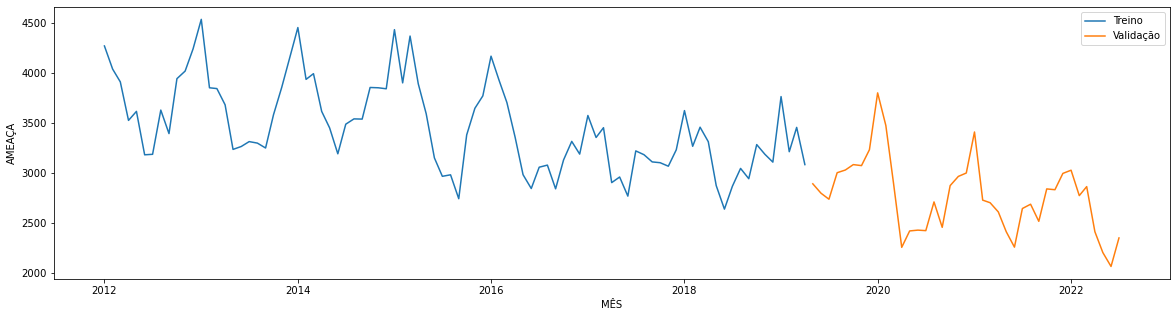

In [141]:
fig, ax = plt.subplots(figsize=(20,5));

sns.lineplot(data=train,
             label = 'Treino',
             ax=ax);

sns.lineplot(data=test,
             label = 'Validação',
             ax=ax);

In [142]:
arima_model = auto_arima(train,
                         start_p=0,
                         d=1,
                         start_q=0,
                         max_p=5,
                         max_d=5,
                         max_q=5,
                         start_P=0,
                         D=1,
                         start_Q=0,
                         max_P=5,
                         max_D=5,
                         max_Q=5,
                         m=12,
                         seasonal=True,
                         trace=True,
                         stepwise=True,
                         n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1047.196, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1027.073, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1043.413, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1018.235, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1016.650, Time=0.53 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1017.880, Time=0.99 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1016.095, Time=0.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1017.841, Time=1.04 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1016.197, Time=0.27 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=1

In [143]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   88
Model:             SARIMAX(2, 1, 3)x(2, 1, [1], 12)   Log Likelihood                -496.439
Date:                              Tue, 20 Sep 2022   AIC                           1010.877
Time:                                      18:57:48   BIC                           1031.735
Sample:                                  01-01-2012   HQIC                          1019.205
                                       - 04-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8835      0.096      9.217      0.000       0.696       1.071
ar.L2         -0.7920      0.123     -6.453      0.000      -1.033      -0.551
ma.L1         -1.3921      0.118    -11.812      0.000      -1.623      -1.161
ma.L2          1.4606      0.146      9.980      0.000       1.174       1.747
ma.L3         -0.7314      0.122     -6.005      0.000      -0.970      -0.493
ar.S.L12      -0.0527      0.362     -0.146      0.884      -0.762       0.657
ar.S.L24      -0.1892      0.215     -0.878      0.380      -0.611       0.233
ma.S.L12      -0.8784      1.098     -0.800      0.424      -3.030       1.273
sigma2      2.419e+04   1.86e+04      1.304      0.192   -1.22e+04    6.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.32   Prob(JB):                         0.71
Heteroskedasticity (H):               0.98   Skew:                            -0.12
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
prediction = pd.DataFrame(arima_model.predict(n_periods=test.shape[0]), index=test.index)
prediction.columns = ['predicted_victims']

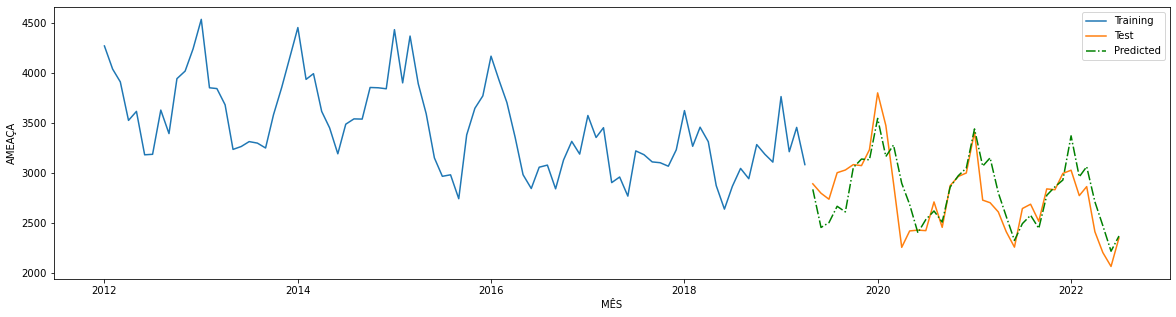

In [145]:
fig, ax = plt.subplots(figsize=(20,5));

sns.lineplot(data=train,
             label = 'Training',
             #ax=ax
             );

sns.lineplot(data=test,
             label = 'Test',
             ax=ax);

sns.lineplot(data=prediction,
             x=prediction.index,
             y=prediction.predicted_victims,
             label = 'Predicted',
             color='g',
             linestyle='-.',
             ax=ax);

In [146]:
# Avaliação do modelo
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(test,
                         prediction,
                         squared=False)
mae = mean_absolute_error(test,
                          prediction)
r2_score = r2_score(test,
                    prediction)
print(f"MSE = {mse:.4f} | MAE = {mae:.4f} | R2 = {r2_score:.4f}")

MSE = 232.1154 | MAE = 178.8893 | R2 = 0.5891


## Modelo Prophet

In [147]:
# Criação do df para o Prophet
data_prophet = df['AMEAÇA'].copy().reset_index().rename(columns={"MÊS": 'ds', "AMEAÇA": 'y'})

In [148]:
train_prophet, test_prophet = train_test_split(data_prophet)

In [149]:
#Defining the Prophet Model
m = Prophet()
#Fitting the data
m.fit(train_prophet);

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\augus\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [150]:
periods = data_prophet.shape[0] - train_prophet.shape[0]
#Making predictions for next X future time stamps
future = m.make_future_dataframe(periods=periods, freq='MS');
forecast = m.predict(future);

C:\Users\augus\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\augus\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


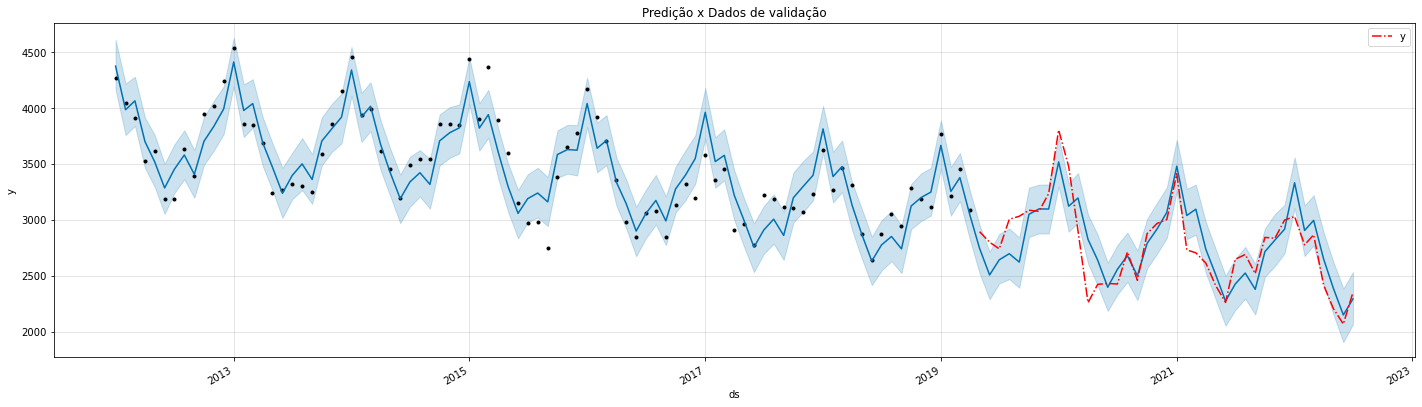

In [151]:
m.plot(forecast, figsize=(20,6))
ax = plt.gca()
test_prophet.plot(c="r", x='ds', y='y', ax=ax, linestyle='-.')
plt.title("Predição x Dados de validação");
ax.yaxis.grid(True)
ax.xaxis.grid(True)

C:\Users\augus\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


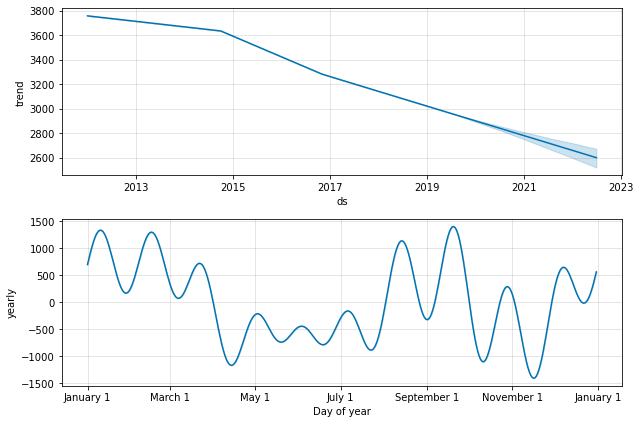

In [152]:
fig2 = m.plot_components(forecast);

In [154]:
from sklearn import metrics
y_hat_val = forecast.yhat[train_prophet.shape[0]:]

mse_prophet = mean_squared_error(test_prophet.y,
                                 y_hat_val,
                                squared=False)

mae_prophet = mean_absolute_error(test_prophet.y,
                                  y_hat_val)

r2_score_prophet = metrics.r2_score(test_prophet.y,
                            y_hat_val)

print(f"Auto ARIMA: MSE = {mse:.4f} | MAE = {mae:.4f} | R2 = {r2_score:.4f}")
print(f"   Prophet: MSE = {mse_prophet:.4f} | MAE = {mae_prophet:.4f} | R2 = {r2_score_prophet:.4f}")

Auto ARIMA: MSE = 232.1154 | MAE = 178.8893 | R2 = 0.5891
   Prophet: MSE = 209.7835 | MAE = 166.1793 | R2 = 0.6644
